<a href="https://colab.research.google.com/github/Gaurav37/Natural-Language-Processing/blob/main/SequencePrediction_Surname_Generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sequence Prediction: Surname Generation

In this experiment, you will explore a simple sequence prediction task: Text generation using a Gated Recurrent Unit (GRU). Like an LSTM, this is an example of a recurrent neural network, but since it has fewer parameters, it should be more appropriate for a smaller dataset.

The GRU computes a probability distribution over the set of possible characters in the surname vocabulary for each time step. We use these probability distributions to generate new surnames. You are given starter code that trains a SurnameGenerationModel on the [surname dataset](https://github.com/jasoriya/CS6120-PS2-support/blob/master/data/surnames/surnames_with_splits.csv) to generate new surnames by learning from the training data. 



Your task is to understand this code and plot the over all perplxity of GRU model as a function of the hidden representation size (K) and the number of characters already observed. You will see **TODO** prompts in the following cells

## Imports

In [ ]:
import os
from argparse import Namespace

import numpy as np
import httpimport
import torch
import torch.optim as optim
from tqdm import tqdm_notebook

# import data preprocessing and modeling functions from https://github.com/jasoriya/CS6120-PS2-support/tree/master/utils
with httpimport.remote_repo(['data_vectorization','model','helper'], 'https://raw.githubusercontent.com/jasoriya/CS6120-PS2-support/master/utils/'):
  from data_vectorization import Vocabulary, SequenceVocabulary, SurnameVectorizer, SurnameDataset, generate_batches
  from model import SurnameGenerationModel, sample_from_model, decode_samples
  from helper import make_train_state, update_train_state, normalize_sizes, compute_accuracy, sequence_loss, set_seed_everywhere, handle_dirs


### Settings and some prep work

**TODO**: 
- Give path to a directory where the model should be saved
- Give hidden state size (`rnn_hidden_size`) for the GRU model (experiment with different levels)


In [ ]:
args = Namespace(
    # Data and Path information
    surname_csv="https://raw.githubusercontent.com/jasoriya/CS6120-PS2-support/master/data/surnames/surnames_with_splits.csv",
    vectorizer_file="vectorizer.json",
    model_state_file="model.pth",
    save_dir= "/", # give path here
    # Model hyper parameters
    char_embedding_size=32,
    rnn_hidden_size= 16, # give hidden size
    # Training hyper parameters
    seed=1337,
    learning_rate=0.001,
    batch_size=128,
    num_epochs=100,
    early_stopping_criteria=5,
    # Runtime options
    catch_keyboard_interrupt=True,
    cuda=True,
    expand_filepaths_to_save_dir=True,
    reload_from_files=False,
)

if args.expand_filepaths_to_save_dir:
    args.vectorizer_file = os.path.join(args.save_dir,
                                        args.vectorizer_file)

    args.model_state_file = os.path.join(args.save_dir,
                                         args.model_state_file)
    
    print("Expanded filepaths: ")
    print("\t{}".format(args.vectorizer_file))
    print("\t{}".format(args.model_state_file))
    
    
# Check CUDA
if not torch.cuda.is_available():
    args.cuda = False

args.device = torch.device("cuda" if args.cuda else "cpu")
    
print("Using CUDA: {}".format(args.cuda))

# Set seed for reproducibility
set_seed_everywhere(args.seed, args.cuda)

# handle dirs
handle_dirs(args.save_dir)

Expanded filepaths: 
	/vectorizer.json
	/model.pth
Using CUDA: True


### Initializations

In [ ]:
if args.reload_from_files:
    # training from a checkpoint
    dataset = SurnameDataset.load_dataset_and_load_vectorizer(args.surname_csv,
                                                              args.vectorizer_file)
else:
    # create dataset and vectorizer
    dataset = SurnameDataset.load_dataset_and_make_vectorizer(args.surname_csv)
    dataset.save_vectorizer(args.vectorizer_file)

vectorizer = dataset.get_vectorizer()

model = SurnameGenerationModel(char_embedding_size=args.char_embedding_size,
                               char_vocab_size=len(vectorizer.char_vocab),
                               rnn_hidden_size=args.rnn_hidden_size,
                               padding_idx=vectorizer.char_vocab.mask_index)
print(model)

SurnameGenerationModel(
  (char_emb): Embedding(88, 32, padding_idx=0)
  (rnn): GRU(32, 16, batch_first=True)
  (fc): Linear(in_features=16, out_features=88, bias=True)
)


### Training loop

In [ ]:
mask_index = vectorizer.char_vocab.mask_index

model = model.to(args.device)


optimizer = optim.Adam(model.parameters(), lr=args.learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                           mode='min', factor=0.5,
                                           patience=1)
train_state = make_train_state(args)

epoch_bar = tqdm_notebook(desc='training routine', 
                          total=args.num_epochs,
                          position=0)

dataset.set_split('train')
#train_bar = tqdm_notebook(desc='split=train',
#                          total=dataset.get_num_batches(args.batch_size), 
#                          position=1, 
#                          leave=True)
dataset.set_split('val')
#val_bar = tqdm_notebook(desc='split=val',
#                        total=dataset.get_num_batches(args.batch_size), 
#                        position=1, 
#                        leave=True)

try:
    for epoch_index in range(args.num_epochs):
        train_state['epoch_index'] = epoch_index

        # Iterate over training dataset

        # setup: batch generator, set loss and acc to 0, set train mode on
        dataset.set_split('train')
        batch_generator = generate_batches(dataset, 
                                           batch_size=args.batch_size, 
                                           device=args.device)
        running_loss = 0.0
        running_acc = 0.0
        model.train()
        
        for batch_index, batch_dict in enumerate(batch_generator):
            # the training routine is these 5 steps:

            # --------------------------------------    
            # step 1. zero the gradients
            optimizer.zero_grad()

            # step 2. compute the output
            y_pred = model(x_in=batch_dict['x_data'])

            # step 3. compute the loss
            loss = sequence_loss(y_pred, batch_dict['y_target'], mask_index)


            # step 4. use loss to produce gradients
            loss.backward()

            # step 5. use optimizer to take gradient step
            optimizer.step()
            # -----------------------------------------
            # compute the  running loss and running accuracy
            running_loss += (loss.item() - running_loss) / (batch_index + 1)
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'], mask_index)
            running_acc += (acc_t - running_acc) / (batch_index + 1)

            # update bar
            #train_bar.set_postfix(loss=running_loss,
            #                      acc=running_acc,
            #                      epoch=epoch_index)
            #train_bar.update()

        train_state['train_loss'].append(running_loss)
        train_state['train_acc'].append(running_acc)

        # Iterate over val dataset

        # setup: batch generator, set loss and acc to 0; set eval mode on
        dataset.set_split('val')
        batch_generator = generate_batches(dataset, 
                                           batch_size=args.batch_size, 
                                           device=args.device)
        running_loss = 0.
        running_acc = 0.
        model.eval()

        for batch_index, batch_dict in enumerate(batch_generator):
            # compute the output
            y_pred = model(x_in=batch_dict['x_data'])

            # step 3. compute the loss
            loss = sequence_loss(y_pred, batch_dict['y_target'], mask_index)

            # compute the  running loss and running accuracy
            running_loss += (loss.item() - running_loss) / (batch_index + 1)
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'], mask_index)
            running_acc += (acc_t - running_acc) / (batch_index + 1)
            
            # Update bar
            #val_bar.set_postfix(loss=running_loss, acc=running_acc, 
            #                epoch=epoch_index)
            #val_bar.update()

        train_state['val_loss'].append(running_loss)
        train_state['val_acc'].append(running_acc)

        train_state = update_train_state(args=args, model=model, 
                                         train_state=train_state)

        scheduler.step(train_state['val_loss'][-1])

        if train_state['stop_early']:
            break
        
        # move model to cpu for sampling
        model = model.cpu()
        sampled_surnames = decode_samples(
            sample_from_model(model, vectorizer, num_samples=2), 
            vectorizer)
        epoch_bar.set_postfix(sample1=sampled_surnames[0], 
                              sample2=sampled_surnames[1])
        # move model back to whichever device it should be on
        model = model.to(args.device)
        
        #train_bar.n = 0
        #val_bar.n = 0
        epoch_bar.update()
        
except KeyboardInterrupt:
    print("Exiting loop")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [ ]:
np.random.choice(np.arange(len(vectorizer.nationality_vocab)), replace=True, size=2)

array([8, 7])

In [ ]:
# compute the loss & accuracy on the test set using the best available model

model.load_state_dict(torch.load(train_state['model_filename']))

model = model.to(args.device)

dataset.set_split('test')
batch_generator = generate_batches(dataset, 
                                   batch_size=args.batch_size, 
                                   device=args.device)
running_acc = 0.
model.eval()

for batch_index, batch_dict in enumerate(batch_generator):
    # compute the output
    y_pred = model(x_in=batch_dict['x_data'])

    # compute the loss
    loss = sequence_loss(y_pred, batch_dict['y_target'], mask_index)

    # compute the accuracy
    running_loss += (loss.item() - running_loss) / (batch_index + 1)

    acc_t = compute_accuracy(y_pred, batch_dict['y_target'], mask_index)
    running_acc += (acc_t - running_acc) / (batch_index + 1)

train_state['test_loss'] = running_loss 
train_state['test_acc'] = running_acc 

**TODO**: Write code to compute the perplexity of the test corpus, the accuracy of a character-prediction task, and the perplexity of the predictive distribution given increasing amounts of context. For this last metric, you want to compute the perplexity of predicting the first character (given nothing to the left), the perplexity of predicting the second character (given the first), and so on, up to the perplexity of predicting the n-th character (given the first 1 to n-1 characters). Unlike an n-gram model, the recurrent model can encode arbitrarily long histories, although it will probably make more use of the nearby context.

In [ ]:
import math
print("Test loss: {};".format(train_state['test_loss']))
print("Test perplexity: {};".format(math.pow(2,running_loss))) # compute and print perplexity here
print("Test Accuracy: {}".format(train_state['test_acc']))

Test loss: 2.665981849034627;
Test perplexity: 6.34659089672326;
Test Accuracy: 22.338558822796756


## Inference
To see the names that the model generates:

In [ ]:
# number of names to generate
num_names = 10
model = model.cpu()
# Generate nationality hidden state
sampled_surnames = decode_samples(
    sample_from_model(model, vectorizer, num_samples=num_names), 
    vectorizer)
# Show results
print ("-"*15)
for i in range(num_names):
    print (sampled_surnames[i])




---------------
Kafnraosy
Ko
Pcohretaer
Csepellhhovn
écvenbgyrsovr
Hanlyere
Kanrair
Muchenvayn
Biuvoyin
Seguibey


**TODO**: Train the GRU model given above multiple times for different levels of `rnn_hidden_size`. For each of these models, plot the average perplexity as a function of the number of characters of the name observed so far. Explain your observations.

In [ ]:
# Your plotting code here

#Lets create models first:
def create_models_diff_hidden(rnn_hidden_size):
  args = Namespace(
    # Data and Path information
    surname_csv="https://raw.githubusercontent.com/jasoriya/CS6120-PS2-support/master/data/surnames/surnames_with_splits.csv",
    vectorizer_file="vectorizer.json",
    model_state_file="model.pth",
    save_dir= "/", # give path here
    # Model hyper parameters
    char_embedding_size=32,
    rnn_hidden_size= rnn_hidden_size, # give hidden size
    # Training hyper parameters
    seed=1337,
    learning_rate=0.001,
    batch_size=128,
    num_epochs=100,
    early_stopping_criteria=5,
    # Runtime options
    catch_keyboard_interrupt=True,
    cuda=True,
    expand_filepaths_to_save_dir=True,
    reload_from_files=False,
  )

  if args.expand_filepaths_to_save_dir:
    args.vectorizer_file = os.path.join(args.save_dir,args.vectorizer_file)
    args.model_state_file = os.path.join(args.save_dir,args.model_state_file)
    print("Expanded filepaths: ")
    print("\t{}".format(args.vectorizer_file))
    print("\t{}".format(args.model_state_file))
      
      
  # Check CUDA
  if not torch.cuda.is_available():
    args.cuda = False

  args.device = torch.device("cuda" if args.cuda else "cpu")
      
  print("Using CUDA: {}".format(args.cuda))

  # Set seed for reproducibility
  set_seed_everywhere(args.seed, args.cuda)

  # handle dirs
  handle_dirs(args.save_dir)
  if args.reload_from_files:
    # training from a checkpoint
    dataset = SurnameDataset.load_dataset_and_load_vectorizer(args.surname_csv,args.vectorizer_file)
  else:
    # create dataset and vectorizer
    dataset = SurnameDataset.load_dataset_and_make_vectorizer(args.surname_csv)
    dataset.save_vectorizer(args.vectorizer_file)

  vectorizer = dataset.get_vectorizer()
  model = SurnameGenerationModel(char_embedding_size=args.char_embedding_size,
                               char_vocab_size=len(vectorizer.char_vocab),
                               rnn_hidden_size=args.rnn_hidden_size,
                               padding_idx=vectorizer.char_vocab.mask_index)
  print(model)
  mask_index = vectorizer.char_vocab.mask_index

  model = model.to(args.device)


  optimizer = optim.Adam(model.parameters(), lr=args.learning_rate)
  scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                            mode='min', factor=0.5,
                                            patience=1)
  train_state = make_train_state(args)

  #epoch_bar = tqdm_notebook(desc='training routine', 
  #                          total=args.num_epochs,
  #                          position=0)

  dataset.set_split('train')
  #train_bar = tqdm_notebook(desc='split=train',
  #                          total=dataset.get_num_batches(args.batch_size), 
  #                          position=1, 
  #                          leave=True)
  dataset.set_split('val')
  #val_bar = tqdm_notebook(desc='split=val',
  #                        total=dataset.get_num_batches(args.batch_size), 
  #                        position=1, 
  #                        leave=True)

  try:

      for epoch_index in range(args.num_epochs):
          train_state['epoch_index'] = epoch_index

          # Iterate over training dataset

          # setup: batch generator, set loss and acc to 0, set train mode on
          dataset.set_split('train')
          batch_generator = generate_batches(dataset, 
                                            batch_size=args.batch_size, 
                                            device=args.device)
          running_loss = 0.0
          running_acc = 0.0
          model.train()
          
          for batch_index, batch_dict in enumerate(batch_generator):
              # the training routine is these 5 steps:

              # --------------------------------------    
              # step 1. zero the gradients
              optimizer.zero_grad()

              # step 2. compute the output
              y_pred = model(x_in=batch_dict['x_data'])

              # step 3. compute the loss
              loss = sequence_loss(y_pred, batch_dict['y_target'], mask_index)


              # step 4. use loss to produce gradients
              loss.backward()

              # step 5. use optimizer to take gradient step
              optimizer.step()
              # -----------------------------------------
              # compute the  running loss and running accuracy
              running_loss += (loss.item() - running_loss) / (batch_index + 1)
              acc_t = compute_accuracy(y_pred, batch_dict['y_target'], mask_index)
              running_acc += (acc_t - running_acc) / (batch_index + 1)

              
          train_state['train_loss'].append(running_loss)
          train_state['train_acc'].append(running_acc)

          # Iterate over val dataset

          # setup: batch generator, set loss and acc to 0; set eval mode on
          dataset.set_split('val')
          batch_generator = generate_batches(dataset, 
                                            batch_size=args.batch_size, 
                                            device=args.device)
          running_loss = 0.
          running_acc = 0.
          model.eval()

          for batch_index, batch_dict in enumerate(batch_generator):
              # compute the output
              y_pred = model(x_in=batch_dict['x_data'])

              # step 3. compute the loss
              loss = sequence_loss(y_pred, batch_dict['y_target'], mask_index)

              # compute the  running loss and running accuracy
              running_loss += (loss.item() - running_loss) / (batch_index + 1)
              acc_t = compute_accuracy(y_pred, batch_dict['y_target'], mask_index)
              running_acc += (acc_t - running_acc) / (batch_index + 1)
              
              # Update bar
              #val_bar.set_postfix(loss=running_loss, acc=running_acc, 
              #                epoch=epoch_index)
              #val_bar.update()

          train_state['val_loss'].append(running_loss)
          train_state['val_acc'].append(running_acc)

          train_state = update_train_state(args=args, model=model, 
                                          train_state=train_state)

          scheduler.step(train_state['val_loss'][-1])

          if train_state['stop_early']:
              break
          
          # move model to cpu for sampling
          model = model.cpu()
          sampled_surnames = decode_samples(
              sample_from_model(model, vectorizer, num_samples=2), 
              vectorizer)
          #epoch_bar.set_postfix(sample1=sampled_surnames[0], 
          #                      sample2=sampled_surnames[1])
          # move model back to whichever device it should be on
          model = model.to(args.device)
          
          #train_bar.n = 0
          #val_bar.n = 0
          #epoch_bar.update()
          
  except KeyboardInterrupt:
      print("Exiting loop")
  train_state['model_filename'] = "./{}_hidden.pt".format(str(rnn_hidden_size))
  torch.save(model.state_dict(), train_state['model_filename'])
  return args, dataset, vectorizer, train_state, model

In [ ]:
model_rnn={}
for hidden_size in [32,64,128,256]:
  model_rnn[hidden_size]=create_models_diff_hidden(hidden_size)

Expanded filepaths: 
	/vectorizer.json
	/model.pth
Using CUDA: True
SurnameGenerationModel(
  (char_emb): Embedding(88, 32, padding_idx=0)
  (rnn): GRU(32, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=88, bias=True)
)
Expanded filepaths: 
	/vectorizer.json
	/model.pth
Using CUDA: True
SurnameGenerationModel(
  (char_emb): Embedding(88, 32, padding_idx=0)
  (rnn): GRU(32, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=88, bias=True)
)
Expanded filepaths: 
	/vectorizer.json
	/model.pth
Using CUDA: True
SurnameGenerationModel(
  (char_emb): Embedding(88, 32, padding_idx=0)
  (rnn): GRU(32, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=88, bias=True)
)
Expanded filepaths: 
	/vectorizer.json
	/model.pth
Using CUDA: True
SurnameGenerationModel(
  (char_emb): Embedding(88, 32, padding_idx=0)
  (rnn): GRU(32, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=88, bias=True)
)


In [ ]:
print(model_rnn.items())
!pwd
!cd ..
!ls

dict_items([(32, (Namespace(batch_size=128, catch_keyboard_interrupt=True, char_embedding_size=32, cuda=True, device=device(type='cuda'), early_stopping_criteria=5, expand_filepaths_to_save_dir=True, learning_rate=0.001, model_state_file='/model.pth', num_epochs=100, reload_from_files=False, rnn_hidden_size=32, save_dir='/', seed=1337, surname_csv='https://raw.githubusercontent.com/jasoriya/CS6120-PS2-support/master/data/surnames/surnames_with_splits.csv', vectorizer_file='/vectorizer.json'), <data_vectorization.SurnameDataset object at 0x7f99a0059470>, <data_vectorization.SurnameVectorizer object at 0x7f99a0059f98>, {'stop_early': False, 'early_stopping_step': 0, 'early_stopping_best_val': 2.540661831696828, 'learning_rate': 0.001, 'epoch_index': 99, 'train_loss': [4.0794039090474445, 3.1958331425984707, 2.9439173936843868, 2.8316943407058712, 2.76467813650767, 2.7252426584561666, 2.6958925525347395, 2.672549136479697, 2.6612891435623176, 2.649063861370087, 2.6366780400276184, 2.62690

In [ ]:
import torch
import torch.nn.functional as F
def perplexity(rnn_sizes):
  rnn_sizes=rnn_sizes
  if rnn_sizes not in [32,64,128,256]:
    print("invalid hidden layer size", rnn_sizes)
    exit(1)
  args, dataset, vectorizer, train_state, model=model_rnn[rnn_sizes]
  #dataset = SurnameDataset.load_dataset_and_make_vectorizer(args.surname_csv)
  #dataset.save_vectorizer(args.vectorizer_file)
  #vectorizer = dataset.get_vectorizer()
  model = SurnameGenerationModel(char_embedding_size=args.char_embedding_size,
                               char_vocab_size=len(vectorizer.char_vocab),
                               rnn_hidden_size=args.rnn_hidden_size,
                               padding_idx=vectorizer.char_vocab.mask_index)
  print(model)
  mask_index = vectorizer.char_vocab.mask_index
  
  model.load_state_dict(torch.load(f'{rnn_sizes}_hidden.pt'))
  model = model.to(args.device)
 
  perplexity=[]
  for i in range(1,20):
    #train_state['epoch_index'] = epoch_index
    # Iterate over training dataset
    # setup: batch generator, set loss and acc to 0, set train mode on
    dataset.set_split('test')
    batch_generator = generate_batches(dataset, 
                                      batch_size=args.batch_size, 
                                      device=args.device)
    running_loss = 0.0
    running_acc = 0.0
    #model.train()
    for batch_index, batch_dict in enumerate(batch_generator):
      x_data = np.array(torch.Tensor.clone(batch_dict['x_data'].cpu()))#
      for j in range(i,19):
        for k in range(x_data.shape[0]):
          x_data[k][j]=0
      x_data = torch.Tensor(x_data).type(torch.LongTensor).to(args.device)
      y_pred=model(x_in=x_data)
      # step 3. compute the loss
      #loss = F.cross_entropy(y_pred,batch_dict['y_target'],mask_index)
      loss= sequence_loss(y_pred,batch_dict['y_target'],mask_index)
      # step 4. use loss to produce gradients
      running_loss += (loss.item() - running_loss) / (batch_index + 1)
      acc_t = compute_accuracy(y_pred, batch_dict['y_target'], mask_index)
      running_acc += (acc_t - running_acc) / (batch_index + 1)
    #perplexity.append(torch.exp(loss))
    perplexity.append(2**running_loss)
  return perplexity

In [ ]:
perplexity_dict={}
for rnn_hidden_size in [32,64,128,256]:
  perplexity_dict[rnn_hidden_size]=perplexity(rnn_hidden_size)

SurnameGenerationModel(
  (char_emb): Embedding(88, 32, padding_idx=0)
  (rnn): GRU(32, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=88, bias=True)
)
SurnameGenerationModel(
  (char_emb): Embedding(88, 32, padding_idx=0)
  (rnn): GRU(32, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=88, bias=True)
)
SurnameGenerationModel(
  (char_emb): Embedding(88, 32, padding_idx=0)
  (rnn): GRU(32, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=88, bias=True)
)
SurnameGenerationModel(
  (char_emb): Embedding(88, 32, padding_idx=0)
  (rnn): GRU(32, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=88, bias=True)
)


rnn_size= 32  // Perplexity [8.557617847995166, 8.155891715293867, 7.862915753573629, 7.455238640600632, 7.0204597828408115, 6.6197141972092375, 6.317571227772091, 6.079565095886211, 5.937496492988748, 5.889404401000829, 5.849023394411432, 5.842519668823394, 5.835220239926828, 5.798650194506488, 5.854616989662379, 5.818697089776425, 5.847138174670977, 5.863903838651079, 5.826290050305066]
rnn_size= 64  // Perplexity [11.621891935061525, 10.751401987313336, 9.008741904926838, 8.354680158994286, 7.39021044884035, 6.622165687334325, 6.068088325794442, 5.736080566889542, 5.534537361546033, 5.4137200840293, 5.397576973757303, 5.334648347256892, 5.353113006266108, 5.327733451864349, 5.331519660191599, 5.3365907176291865, 5.354179854213199, 5.352306928747237, 5.3548662292439655]
rnn_size= 128  // Perplexity [11.490425395944513, 10.294960636806893, 8.905800294633465, 8.012661810580267, 7.06865791890815, 6.252095518425041, 5.698895523897865, 5.352434964227079, 5.1091865178138605, 4.986592659438

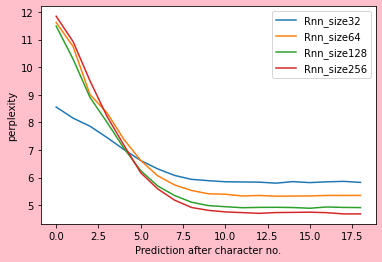

In [ ]:
for rnn_hidden_size in [32,64,128,256]:
  print("rnn_size=",rnn_hidden_size," // Perplexity" ,perplexity_dict[rnn_hidden_size])

#import matplotlib as plt
import matplotlib.pyplot as plt 

plt.figure(facecolor="pink")
for k,v in perplexity_dict.items():
  plt.plot(range(0,19),v,label="Rnn_size"+str(k))
plt.xlabel("Prediction after character no.")
plt.ylabel("perplexity")
plt.legend()
plt.show()

The results of this experiments are as folllows:
There seems not much difference in models with hidden RNN size larger than 32. 
The difference starts appearing at 7 character level where higher rnn sizes perform better with one unit less perplexity.

32 bit performs better initially when not enough data is available which might be because of overfitting in case of higher hidden RNNs as less data is available initially.
As the models learn more characters the higher level RNN perform much better.